In [1]:
!nvidia-smi

Sat Mar  6 19:34:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 36kB/s 


In [3]:
!pip install livelossplot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/New folder'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from livelossplot import PlotLossesKeras


/content/drive/MyDrive/New folder/MAMO_BCD.ipynb
/content/drive/MyDrive/New folder/MAMO_BCD.h5
/content/drive/MyDrive/New folder/MAMO_FDG.ipynb
/content/drive/MyDrive/New folder/MAMO_FDG_utilizer.ipynb
/content/drive/MyDrive/New folder/MAMO_BCD_BMN.h5
/content/drive/MyDrive/New folder/MAMO_BMN_utilizer.ipynb
/content/drive/MyDrive/New folder/MAMO_BMN_model.ipynb
/content/drive/MyDrive/New folder/MAMO_utilizer.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_BCD-checkpoint.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_FDG-checkpoint.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_FDG_utilizer-checkpoint.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_BMN_utilizer-checkpoint.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_BMN_model-checkpoint.ipynb
/content/drive/MyDrive/New folder/.ipynb_checkpoints/MAMO_utilizer-checkpoint.ipynb
/content/drive/MyDrive/New folder/dataset/all-mias.tar.gz
/content/drive/MyDri

In [7]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
# import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [8]:
info=pd.read_csv('/content/drive/MyDrive/New folder/dataset/Info.txt',sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,N,NaN,NaN,NaN
3,mdb004,D,NORM,N,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,N,NaN,NaN,NaN
326,mdb319,D,NORM,N,NaN,NaN,NaN
327,mdb320,D,NORM,N,NaN,NaN,NaN
328,mdb321,D,NORM,N,NaN,NaN,NaN


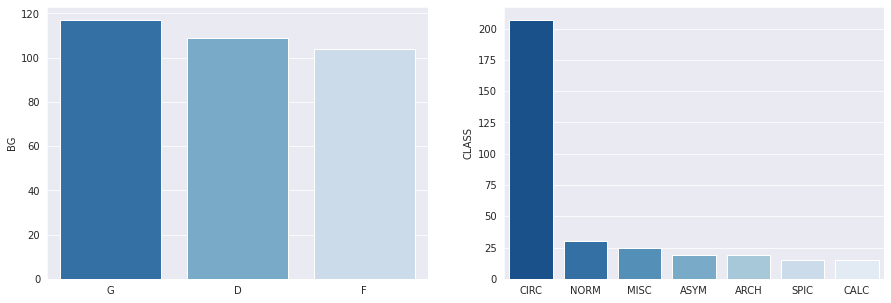

In [9]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)


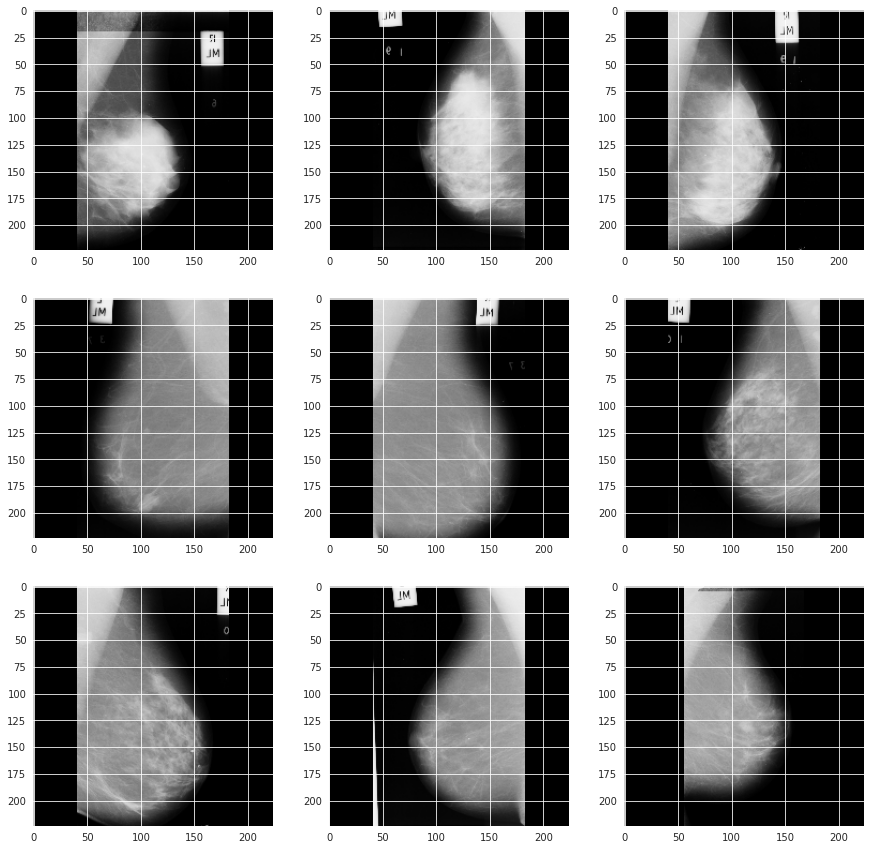

In [10]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("/content/drive/MyDrive/New folder/dataset/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [11]:
# Image Augmentation
no_angles = 360
url = "/content/drive/MyDrive/New folder/dataset/all-mias/"

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [12]:
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)

In [13]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))    

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0
            
    return (info)

In [14]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys() 

X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
10143 3042 1305


In [15]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=3

In [16]:
base_Neural_Net= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


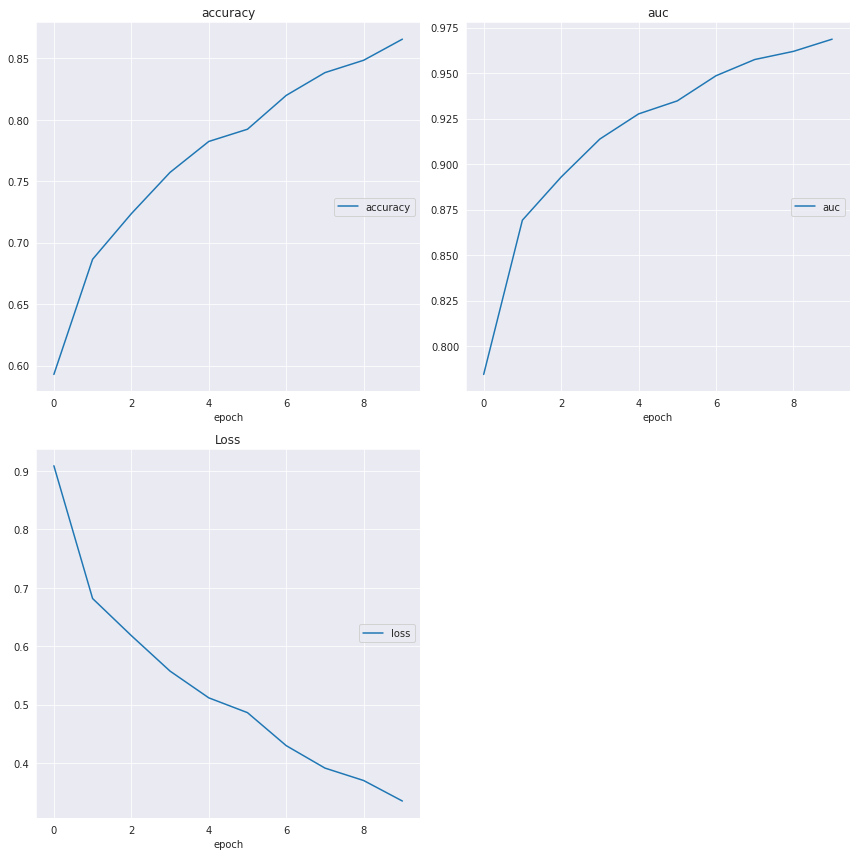

accuracy
	accuracy         	 (min:    0.593, max:    0.866, cur:    0.866)
auc
	auc              	 (min:    0.784, max:    0.969, cur:    0.969)
Loss
	loss             	 (min:    0.335, max:    0.909, cur:    0.335)


In [17]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [18]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 9s 42ms/step - loss: 0.5345 - accuracy: 0.7959 - auc: 0.9325


[0.5344516634941101, 0.7958579659461975, 0.932501494884491]

In [19]:
print("Performance Report:")
y_pred8=model.predict_classes(x_test)
y_test8=[np.argmax(x) for x in y_test]
y_pred_prb8=model.predict_proba(x_test)
target=["F","D","G"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test8, y_pred8),4))
print('Precision score is :', np.round(metrics.precision_score(y_test8, y_pred8, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test8,y_pred8, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test8, y_pred8, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test8, y_pred_prb8,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test8, y_pred8),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test8, y_pred8,target_names=target))

Performance Report:
Accuracy score is : 0.8
Precision score is : 0.7986
Recall score is : 0.8
F1 Score is : 0.7979
ROC AUC Score is : 0.9367
Cohen Kappa Score: 0.6997
		Classification Report:
               precision    recall  f1-score   support

           F       0.83      0.89      0.86       392
           D       0.80      0.83      0.81       461
           G       0.78      0.69      0.73       452

    accuracy                           0.80      1305
   macro avg       0.80      0.80      0.80      1305
weighted avg       0.80      0.80      0.80      1305



In [20]:
model.save("MAMO_FDG_InceptionV3.h5")

In [21]:
from tensorflow.keras.preprocessing import image
models=load_model("MAMO_FDG_InceptionV3.h5")

(array([[0.0017623 , 0.02600182, 0.9722359 ]], dtype=float32), 97.2236, 'G')


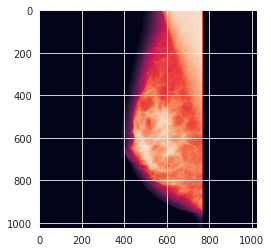

In [24]:
def predictor(filename) :
    test_image = filename
    image_result = Image.open(test_image)
    # test_image = image.load_img(test_image, target_size=(100,100))
    test_image = image.load_img(test_image, target_size=(224,224,3))
    test_image = image.img_to_array(test_image)
#     test_image = test_image/255
    test_image = np.expand_dims(test_image, axis=0)
    result = models.predict(test_image)
    r = np.max(result)
    per = r*100
    percentage = round(per,4)
    categories = ['F','D','G']
    image_result = plt.imshow(image_result)
    output = categories[np.argmax(result)]
    return result,percentage,output


CANCER_DETECTOR = predictor('/content/drive/MyDrive/New folder/dataset/all-mias/mdb055.pgm')
print(CANCER_DETECTOR)